<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from sklearn.metrics import accuracy_score

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/daniil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [4]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предложения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [5]:
sentences = []
word_threshold = 32
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence.replace('<br /><br />', ' '), language='english') if len(word_tokenize(x)) < word_threshold]
        )
    
# Получить отдельные предложения и поместить их в sentences
print("Всего предложений:", len(sentences))

  0%|          | 0/25000 [00:00<?, ?it/s]

Всего предложений: 253311


In [6]:
words = Counter()

for sentence in tqdm(sentences):
    for wrd in word_tokenize(sentence):
        words[wrd] += 1
words = words.most_common()        

  0%|          | 0/253311 [00:00<?, ?it/s]

In [7]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

for i in range(vocab_size):
    vocab.add(words[i][0])

assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [8]:
word2ind = {wrd: i for i, wrd in enumerate(vocab)}
ind2word = {i: wrd for wrd, i in word2ind.items()}

In [9]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(wrd, self.unk_id) for wrd in self.data[idx]] 
        tokenized_sentence += [self.eos_id]


        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [10]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [11]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 40

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возможные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

In [12]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    val_acc = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())
            acc = accuracy_score(torch.argmax(logits,1).to('cpu'), batch['target_ids'].flatten().to('cpu'))
            val_acc.append(acc)
    perplexity = sum(perplexity) / len(perplexity)
    
    return perplexity, sum(val_acc)/len(val_acc)

In [13]:
def train_model(model, num_epoch=5):
    
    losses = []
    perplexities = []
    tr_acc = []
    val_acc = []
    
    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            acc = accuracy_score(torch.argmax(logits,1).to('cpu'), batch['target_ids'].flatten().to('cpu'))
            loss.backward()
            optimizer.step()
    
            epoch_losses.append(loss.item())
        tr_acc.append(np.mean(acc))
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perp, acc = evaluate(model, criterion, eval_dataloader)
        perplexities.append(perp)
        val_acc.append(acc)
        
    return model, losses, perplexities, tr_acc, val_acc

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

# Построим LSTM архитектуру

In [14]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim,num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))
        
        return projection

In [15]:
model = LanguageModel(128, len(vocab)).to(device)

In [16]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [17]:
model, losses, perplexities, tr_acc, val_acc = train_model(model, num_epoch=5)

Training epoch 0::   0%|          | 0/5067 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/5067 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/5067 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/5067 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/5067 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Loss function')

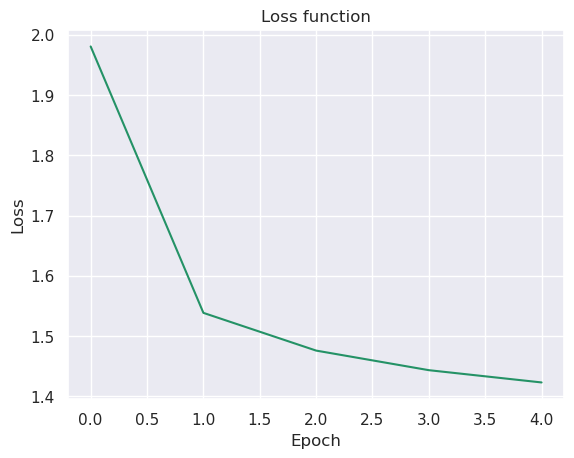

In [18]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss function')

Text(0.5, 1.0, 'Perplexity function')

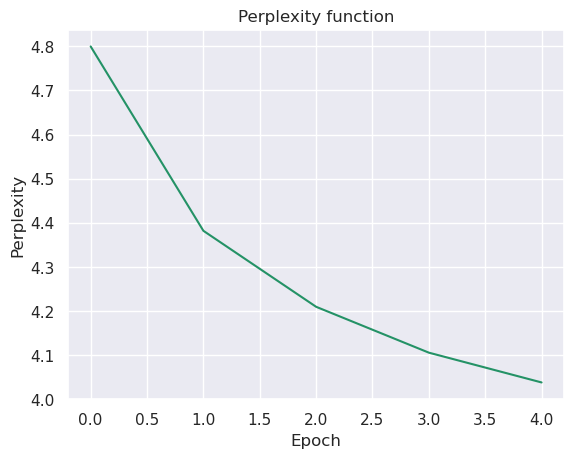

In [19]:
plt.plot(perplexities)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity function')

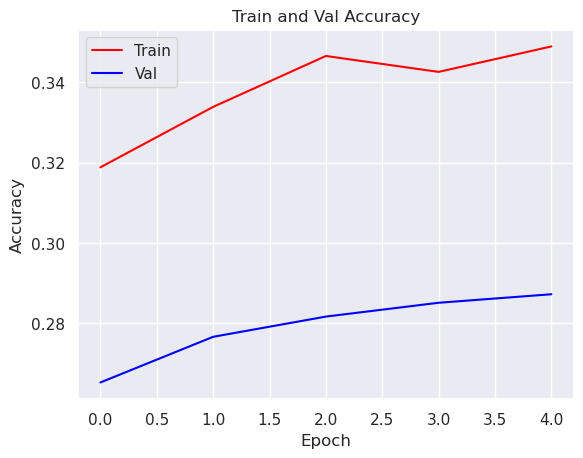

In [20]:
plt.plot(tr_acc, color='red')
plt.plot(val_acc, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Val Accuracy')
plt.legend(['Train','Val'])

# Проверим модель на тестовой выборке

In [21]:
perp, acc = evaluate(model, criterion, test_dataloader)

In [22]:
print(f'Перплексия на тесте: {perp}, точность на тесте: {acc}')

Перплексия на тесте: 4.039741135863125, точность на тесте: 0.28758006331557967


### Второй эксперимент (2 балла)


# Применим GRU  с другим оптимизатором

In [23]:
class LanguageModel2(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim,num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))
        
        return projection

In [24]:
model2 = LanguageModel2(128, len(vocab)).to(device)

In [25]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.RMSprop(model.parameters())

In [26]:
model2, losses2, perplexities2, tr_acc2, val_acc2 = train_model(model, num_epoch=5)

Training epoch 0::   0%|          | 0/5067 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/5067 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/5067 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/5067 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/5067 [00:00<?, ?it/s]

# Проверим модель на тестовой выборке

In [27]:
perp2, acc2 = evaluate(model2, criterion, test_dataloader)

In [28]:
print(f'Перплексия на тесте: {perp2}, точность на тесте: {acc2}')

Перплексия на тесте: 4.743532410020289, точность на тесте: 0.2637194397321334


Text(0.5, 1.0, 'Loss function')

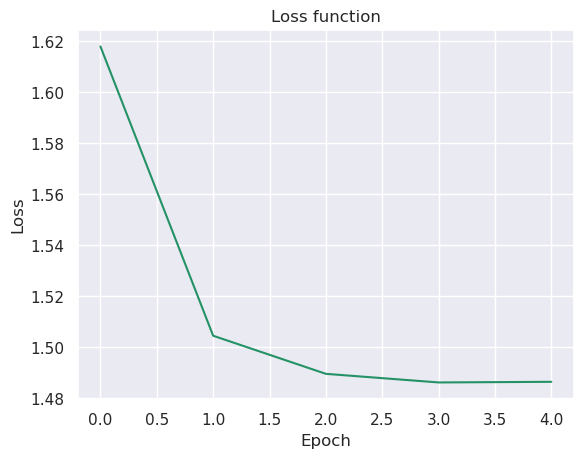

In [30]:
plt.plot(losses2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss function')

Text(0.5, 1.0, 'Perplexity function')

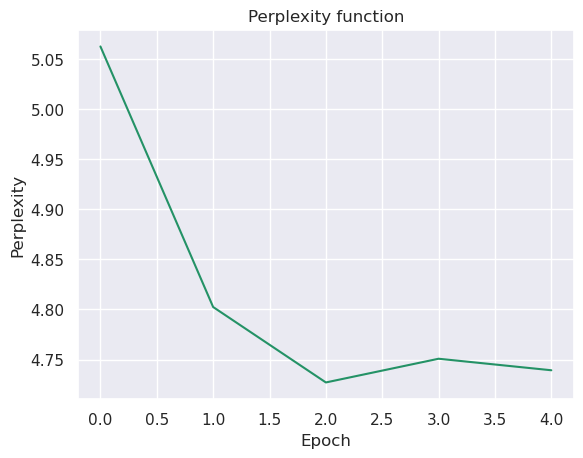

In [31]:
plt.plot(perplexities2)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity function')

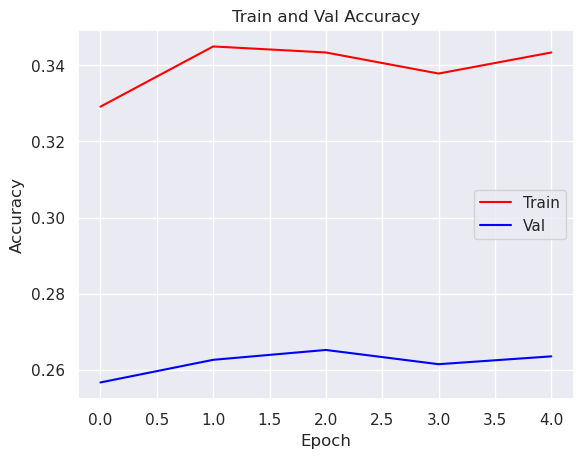

In [32]:
plt.plot(tr_acc2, color='red')
plt.plot(val_acc2, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Val Accuracy')
plt.legend(['Train','Val'])

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

    Как мы видим, модель на основе 'LSTM' отрпботала лучше. 
    У модели 'LSTM' точность: 0.2875 перплексия: 4.0397
    У модели '' точность: перплексия: 0.2637 loss: 4.7435

В качестве мер по улучшению результата я бы начал испльзовать более подходящие для этого архитектуры, например Transformer